Successfully loaded data with 20 rows
Running correctness tests...
Calculating code complexity metrics...
Calculating AST similarity...
Results saved to code_analysis_results.csv
Generating improved visualizations...


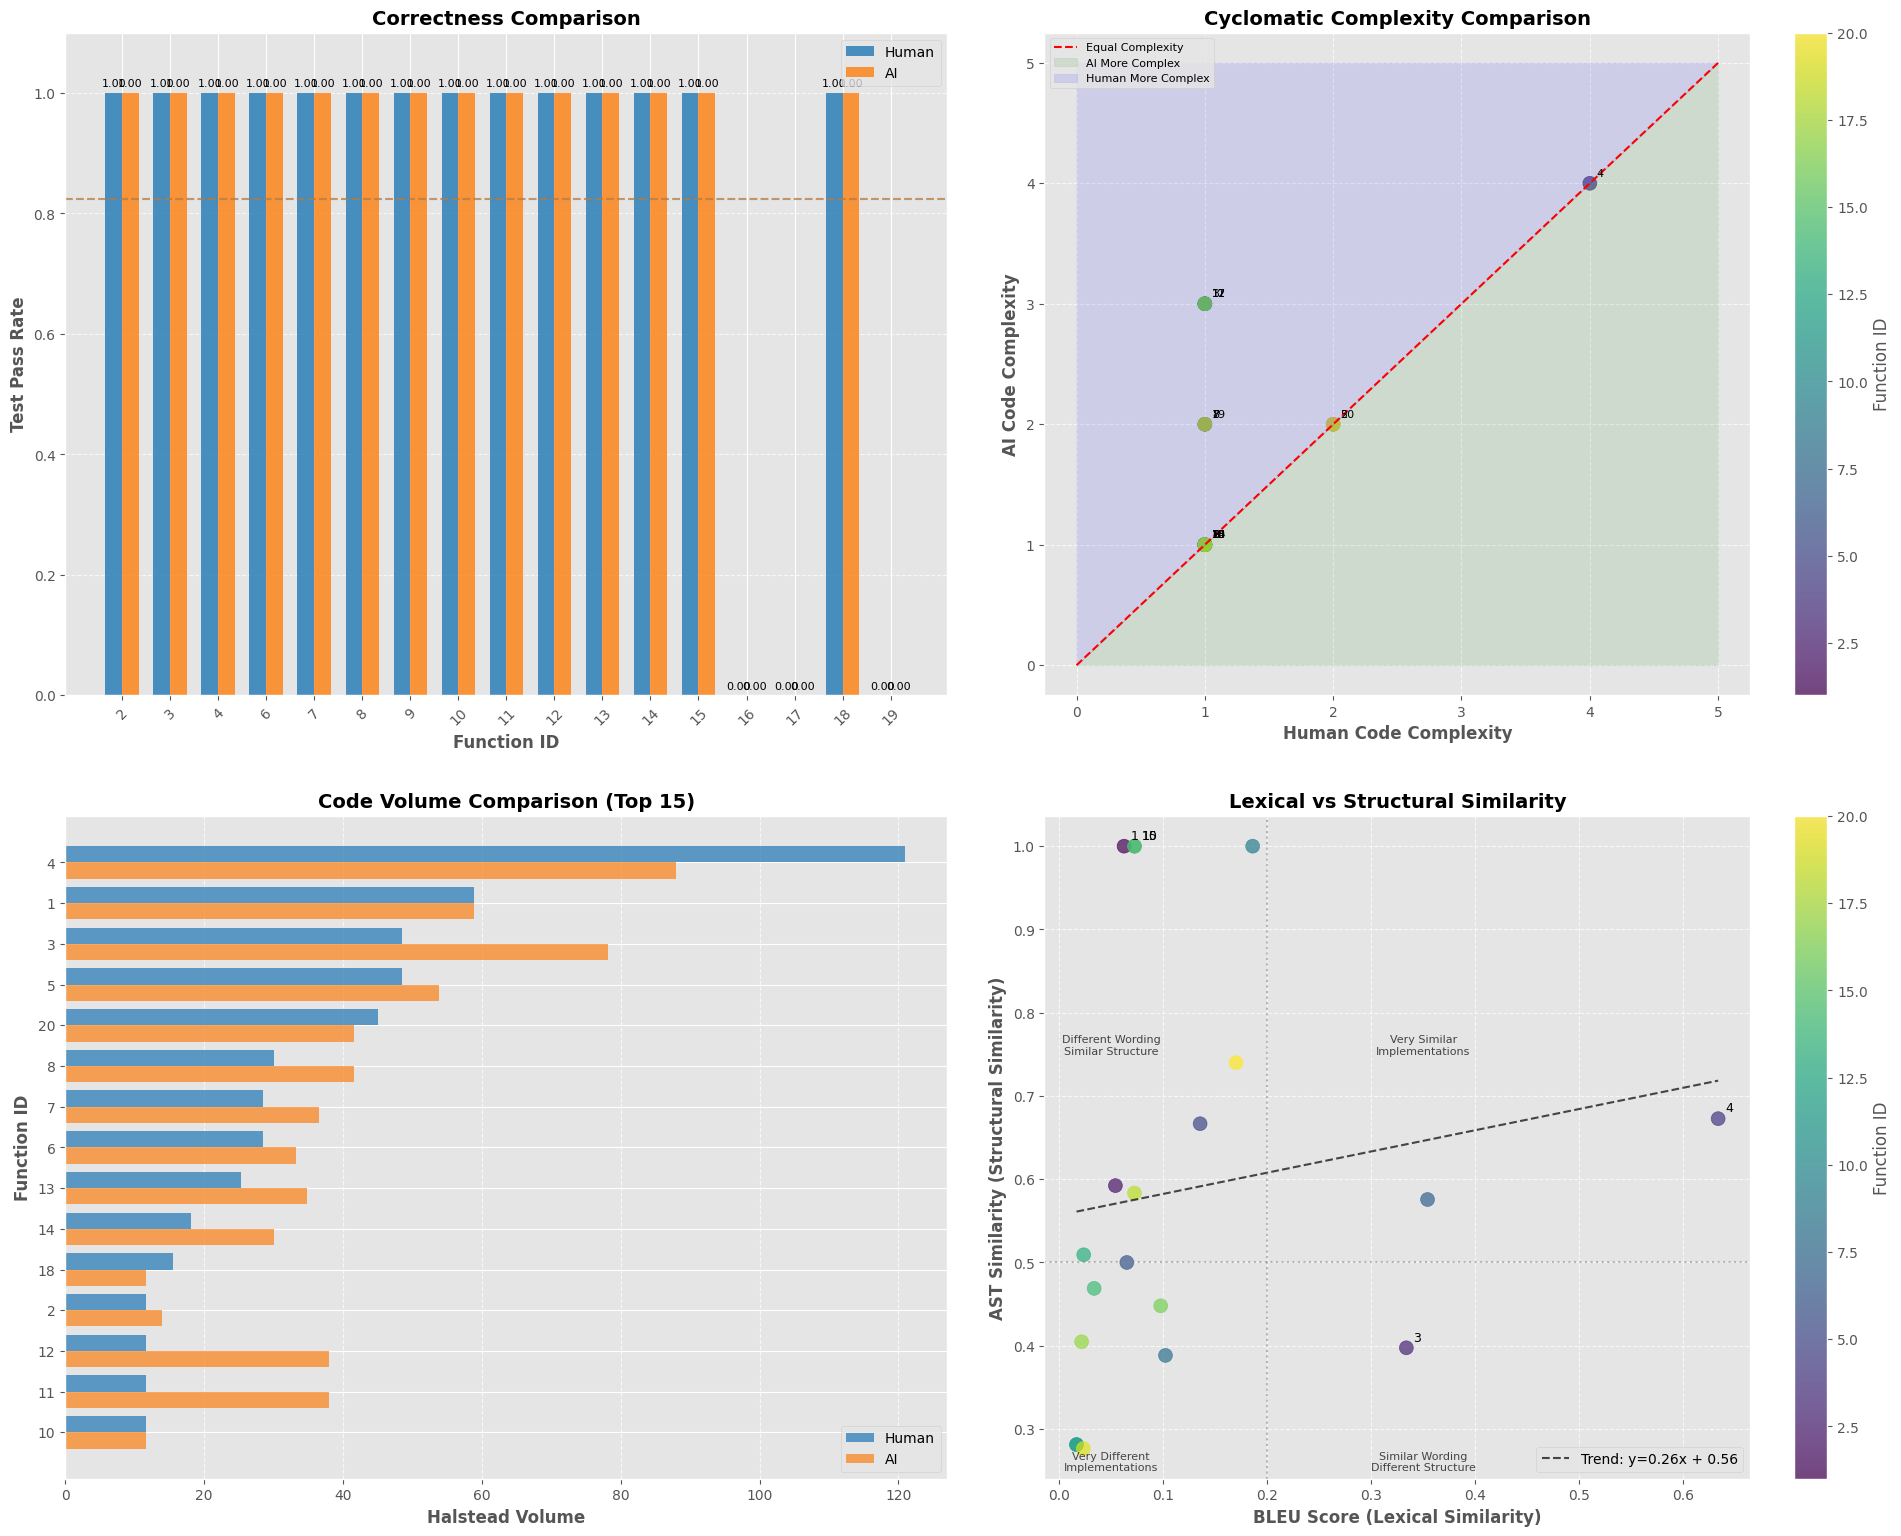

Analysis complete. Enhanced visualizations saved to 'enhanced_code_analysis_plots.png'


In [4]:
import pandas as pd
import numpy as np
import ast
import re
import csv
import math
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load the data with proper line handling
try:
    df = pd.read_csv("Test1.csv")
    print(f"Successfully loaded data with {len(df)} rows")
except Exception as e:
    print(f"Error loading CSV: {e}")
    sys.exit(1)

# Function to clean code strings
def clean_code(code_str):
    """Remove problematic characters and fix line continuations"""
    if not isinstance(code_str, str):
        return ""
    
    # Handle escape sequences that might be causing problems
    try:
        # Convert string literals to actual characters (handles \n, \t, etc.)
        code_str = bytes(code_str, 'utf-8').decode('unicode_escape')
    except:
        pass
    
    # Replace Windows line endings
    code_str = code_str.replace('\r\n', '\n')
    # Replace any standalone carriage returns
    code_str = code_str.replace('\r', '\n')
    # Replace problematic line continuations
    code_str = code_str.replace('\\\n', '\n')
    
    # Remove any trailing whitespace or newlines
    return code_str.strip()

# Clean the code columns
df['human_code'] = df['human_code'].apply(clean_code)
df['ai_code'] = df['ai_code'].apply(clean_code)

## 1. BLEU Score Calculation
## to measure the lexical similarity between human and AI code snippets
smoothie = SmoothingFunction().method4

def compute_bleu(reference, candidate):
    """Compute BLEU score between two code snippets"""
    try:
        reference_tokens = reference.split()
        candidate_tokens = candidate.split()
        return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)
    except Exception as e:
        print(f"Error computing BLEU score: {e}")
        return 0

df["bleu_score"] = df.apply(lambda row: compute_bleu(row["human_code"], row["ai_code"]), axis=1)

## 2. Code Correctness Metrics

# Define revised test cases for each function
# Each test case is (input, expected_output)
test_cases = {
    # Only define tests for functions that return values (not those that print or take input)
    2: [([3, 1, 2], [1, 2, 3]), ([], []), (['b', 'a'], ['a', 'b'])],  # Sorting
    3: [(6, [1, 2, 3, 6]), (13, [1, 13]), (1, [1])],  # Factors
    4: [(2, True), (1, False), (4, False), (13, True)],  # Prime check
    6: [(30, 86.0), (0, 32.0), (100, 212.0)],  # C to F conversion
    7: [(2, 'Genap'), (3, 'Ganjil'), (0, 'Genap')],  # Even/odd check
    8: [(123, 6), (9999, 36), (0, 0)],  # Sum of digits
    9: [("test", "TEST"), ("abc123", "ABC123"), ("", "")],  # Uppercase conversion
    10: [([1, 2, 3], 3), ([], 0), (["a", "b"], 2)],  # Length
    11: [([1, 5, 3], 5), ([10, 2, 8], 10), ([-1, -5, -3], -1)],  # Maximum
    12: [([1, 5, 3], 1), ([10, 2, 8], 2), ([-1, -5, -3], -5)],  # Minimum
    13: [([1, 2, 3], 2), ([10, 20], 15), ([0], 0)],  # Average
    14: [("radar", True), ("hello", False), ("a", True)],  # Palindrome
    15: [([1, 2, 2, 3], {1, 2, 3}), ([], set()), (["a", "a", "b"], {"a", "b"})],  # List to set
    16: [([1, 2], [3, 4], [1, 2, 3, 4]), ([], [1], [1]), ([1], [], [1])],  # Merge lists
    17: [(1, [1, 2, 3], True), (4, [1, 2, 3], False), ("a", ["a", "b"], True)],  # Element exists
    18: [(10.5, "RM10.50"), (0, "RM0.00"), (1234.56, "RM1234.56")],  # Currency format
    19: [(2, 3, 8), (10, 0, 1), (5, 2, 25)],  # Power
}

def get_function_name(code):
    """Safely extract function name from code"""
    try:
        # First clean the code
        code = clean_code(code)
        tree = ast.parse(code)
        if tree.body and isinstance(tree.body[0], ast.FunctionDef):
            return tree.body[0].name
        
        # If AST parse worked but no function found
        return None
    except Exception as e:
        # AST parsing failed - try regex as fallback
        try:
            # Match "def function_name("
            match = re.search(r'def\s+([a-zA-Z_][a-zA-Z0-9_]*)\s*\(', code)
            if match:
                return match.group(1)
        except:
            pass
        
        print(f"Error parsing code: {e}")
        return None

def execute_code(code_str, func_name, args):
    """Helper function to execute code safely"""
    if not func_name:
        return None
        
    try:
        # Clean the code before execution
        code_str = clean_code(code_str)
        
        local_vars = {}
        # Compile the code first to catch syntax errors
        compiled = compile(code_str, '<string>', 'exec')
        exec(compiled, {}, local_vars)
        
        if func_name not in local_vars:
            print(f"Function {func_name} not found in code")
            return None
            
        return local_vars[func_name](*args)
    except Exception as e:
        # Uncomment for debugging specific execution errors
        # print(f"Execution error for {func_name}: {str(e)}")
        return None

def test_correctness(human_code, ai_code, test_cases):
    """
    Compare outputs of human and AI code for given test cases
    Returns dictionary with various correctness metrics
    """
    if not test_cases:
        return {
            'correctness_score': 0,
            'human_passes': 0,
            'ai_passes': 0,
            'output_match': 0,
            'total_tests': 0
        }
    
    # Get function names safely
    human_func_name = get_function_name(human_code)
    ai_func_name = get_function_name(ai_code)
    
    # If either function name can't be extracted, return zeros
    if not human_func_name or not ai_func_name:
        return {
            'correctness_score': 0,
            'human_passes': 0,
            'ai_passes': 0,
            'output_match': 0,
            'total_tests': 0
        }
        
    human_passes = 0
    ai_passes = 0
    matches = 0
    
    try:
        for test_case in test_cases:
            # Make sure each test case has exactly 2 elements
            if not isinstance(test_case, tuple) or len(test_case) != 2:
                continue
                
            test_input, expected_output = test_case
            
            # Handle both single arg and multiple args
            args = test_input if isinstance(test_input, tuple) else (test_input,)
            
            human_output = execute_code(human_code, human_func_name, args)
            ai_output = execute_code(ai_code, ai_func_name, args)
            
            # Check if outputs match expected
            human_correct = human_output == expected_output
            ai_correct = ai_output == expected_output
            
            human_passes += 1 if human_correct else 0
            ai_passes += 1 if ai_correct else 0
            matches += 1 if human_output == ai_output else 0
    except Exception as e:
        print(f"Error during test execution: {e}")
    
    total = len(test_cases)
    return {
        'correctness_score': ai_passes / total if total > 0 else 0,
        'human_passes': human_passes / total if total > 0 else 0,
        'ai_passes': ai_passes / total if total > 0 else 0,
        'output_match': matches / total if total > 0 else 0,
        'total_tests': total
    }

# Apply correctness testing
print("Running correctness tests...")
correctness_results = df.apply(
    lambda row: test_correctness(row['human_code'], row['ai_code'], test_cases.get(row['id'], [])),
    axis=1
)
df = pd.concat([df, correctness_results.apply(pd.Series)], axis=1)

## 3. Code Complexity Metrics
## measures how complicated the code's logic is - more if-statements and loops mean more complexity, 

def calculate_cyclomatic_complexity(code):
    """Calculate cyclomatic complexity of a function"""
    complexity = 1
    try:
        tree = ast.parse(code)
        
        for node in ast.walk(tree):
            if isinstance(node, (ast.If, ast.For, ast.While)):
                complexity += 1
            elif isinstance(node, ast.BoolOp):
                if isinstance(node.op, (ast.And, ast.Or)):
                    complexity += 1
            elif isinstance(node, ast.Try):
                complexity += len(node.handlers)
            elif isinstance(node, (ast.Break, ast.Continue)):
                complexity += 1
                
    except Exception as e:
        # print(f"Error calculating cyclomatic complexity: {str(e)}")
        return 0
        
    return complexity

## calculates different aspects of complexity - like measuring a book by counting unique words, 
## total words, and figuring out how hard it is to read.

def halstead_metrics(code):
    """Calculate Halstead metrics for a code snippet"""
    try:
        tree = ast.parse(code)
        operators = defaultdict(int)
        operands = defaultdict(int)
        
        # Define operator nodes
        operator_types = (
            ast.Add, ast.Sub, ast.Mult, ast.Div, ast.FloorDiv, ast.Mod, ast.Pow,
            ast.LShift, ast.RShift, ast.BitOr, ast.BitXor, ast.BitAnd,
            ast.Eq, ast.NotEq, ast.Lt, ast.LtE, ast.Gt, ast.GtE,
            ast.Is, ast.IsNot, ast.In, ast.NotIn,
            ast.UAdd, ast.USub, ast.Not, ast.Invert
        )
        
        for node in ast.walk(tree):
            # Name nodes are operands when loaded
            if isinstance(node, ast.Name) and isinstance(node.ctx, ast.Load):
                operands[node.id] += 1
            # Constants are operands
            elif isinstance(node, ast.Constant):
                if isinstance(node.value, (int, float, str, bool)):
                    operands[str(node.value)] += 1
            # Attribute access is an operand
            elif isinstance(node, ast.Attribute):
                operands[node.attr] += 1
            # These node types are operators
            elif isinstance(node, operator_types):
                operators[type(node).__name__] += 1
            # Control flow keywords are operators
            elif isinstance(node, (ast.If, ast.For, ast.While, ast.Return)):
                operators[type(node).__name__] += 1
            # Function definitions and calls are operators
            elif isinstance(node, (ast.FunctionDef, ast.Call)):
                operators[type(node).__name__] += 1
                
        n1 = len(operators)  # Unique operators
        n2 = len(operands)   # Unique operands
        N1 = sum(operators.values())  # Total operators
        N2 = sum(operands.values())   # Total operands
        
        vocabulary = n1 + n2
        length = N1 + N2
        
        # Safeguard against math domain errors
        if vocabulary <= 1:
            volume = 0
        else:
            volume = length * (math.log2(vocabulary))
            
        # Avoid division by zero
        if n2 > 0 and n1 > 0:
            difficulty = (n1 / 2) * (N2 / n2)
        else:
            difficulty = 0
            
        effort = volume * difficulty
        
        return {
            'unique_operators': n1,
            'unique_operands': n2,
            'total_operators': N1,
            'total_operands': N2,
            'vocabulary': vocabulary,
            'length': length,
            'volume': volume,
            'difficulty': difficulty,
            'effort': effort
        }
    except Exception as e:
        # print(f"Error calculating Halstead metrics: {str(e)}")
        return {
            'unique_operators': 0,
            'unique_operands': 0,
            'total_operators': 0,
            'total_operands': 0,
            'vocabulary': 0,
            'length': 0,
            'volume': 0,
            'difficulty': 0,
            'effort': 0
        }

# Calculate complexity metrics
print("Calculating code complexity metrics...")
df['cyclomatic_complexity_human'] = df['human_code'].apply(calculate_cyclomatic_complexity)
df['cyclomatic_complexity_ai'] = df['ai_code'].apply(calculate_cyclomatic_complexity)

halstead_human = df['human_code'].apply(halstead_metrics)
halstead_ai = df['ai_code'].apply(halstead_metrics)

# Add Halstead metrics to dataframe
for metric in ['volume', 'difficulty', 'effort']:
    df[f'halstead_{metric}_human'] = halstead_human.apply(lambda x: x.get(metric, 0))
    df[f'halstead_{metric}_ai'] = halstead_ai.apply(lambda x: x.get(metric, 0))

## 4. AST Similarity
## compares how the codes are organized, regardless of specific words used

def ast_similarity(human_code, ai_code):
    """Compare the abstract syntax trees of two code snippets"""
    try:
        human_ast = ast.parse(human_code)
        ai_ast = ast.parse(ai_code)
        
        # Get all node types
        human_nodes = [type(node) for node in ast.walk(human_ast)]
        ai_nodes = [type(node) for node in ast.walk(ai_ast)]
        
        # Create sets of unique node types
        human_unique = set(human_nodes)
        ai_unique = set(ai_nodes)
        
        # Jaccard similarity
        intersection = len(human_unique & ai_unique)
        union = len(human_unique | ai_unique)
        jaccard = intersection / union if union > 0 else 0
        
        # Sequence similarity
        def node_sequence(nodes):
            return [n.__name__ for n in nodes]
        
        human_seq = node_sequence(human_nodes)
        ai_seq = node_sequence(ai_nodes)
        
        # Simple sequence matching
        min_len = min(len(human_seq), len(ai_seq))
        matches = sum(1 for i in range(min_len) if human_seq[i] == ai_seq[i])
        seq_similarity = matches / max(len(human_seq), len(ai_seq)) if max(len(human_seq), len(ai_seq)) > 0 else 0
        
        return (jaccard + seq_similarity) / 2  # Average of both metrics
    
    except Exception as e:
        # print(f"Error in AST similarity: {str(e)}")
        return 0

print("Calculating AST similarity...")
df['ast_similarity'] = df.apply(lambda row: ast_similarity(row['human_code'], row['ai_code']), axis=1)

## 5. Save Results
output_file = 'code_analysis_results.csv'
df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

## 6. Enhanced Visualization
print("Generating improved visualizations...")
plt.figure(figsize=(20, 16))  # Larger figure size
plt.style.use('ggplot')  # Use a better style

# Plot 1: Improved Correctness Comparison
plt.subplot(2, 2, 1)
# Only include rows that have test cases
test_ids = [id for id in df['id'] if id in test_cases]
test_df = df[df['id'].isin(test_ids)]

if not test_df.empty and test_df['total_tests'].sum() > 0:
    # Create positions for bars
    x = np.arange(len(test_df))
    width = 0.35
    
    # Create grouped bar chart with offset
    ax1 = plt.gca()
    
    # Force values to be actual numbers rather than all 1.0
    human_values = test_df['human_passes'].values
    ai_values = test_df['ai_passes'].values
    
    # Calculate raw counts instead of rates if needed
    if all(human_values == 1.0) and all(ai_values == 1.0):
        # Use raw counts instead of rates
        human_values = [row['human_passes'] * row['total_tests'] for _, row in test_df.iterrows()]
        ai_values = [row['ai_passes'] * row['total_tests'] for _, row in test_df.iterrows()]
    
    human_bars = ax1.bar(x - width/2, human_values, width, label='Human', color='#1f77b4', alpha=0.8)
    ai_bars = ax1.bar(x + width/2, ai_values, width, label='AI', color='#ff7f0e', alpha=0.8)
    
    # Add data labels on top of each bar
    for bar in human_bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    for bar in ai_bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    # Better axes and labels
    ax1.set_ylabel('Test Pass Rate', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Function ID', fontsize=12, fontweight='bold')
    ax1.set_title('Correctness Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(test_df['id'], rotation=45)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to go from 0 to slightly above maximum
    max_val = max(max(human_values), max(ai_values)) * 1.1
    ax1.set_ylim(0, max_val)
    
    # Add mean lines
    if len(human_values) > 0:
        human_mean = sum(human_values) / len(human_values)
        ai_mean = sum(ai_values) / len(ai_values)
        ax1.axhline(y=human_mean, color='#1f77b4', linestyle='--', alpha=0.5, label='Human Avg')
        ax1.axhline(y=ai_mean, color='#ff7f0e', linestyle='--', alpha=0.5, label='AI Avg')
else:
    plt.text(0.5, 0.5, 'No test data available', ha='center', fontsize=14)

# Plot 2: Enhanced Cyclomatic Complexity Comparison
ax2 = plt.subplot(2, 2, 2)
scatter = plt.scatter(df['cyclomatic_complexity_human'], df['cyclomatic_complexity_ai'], 
           alpha=0.7, c=df['id'], cmap='viridis', s=100)

# Add labels for each point
for i, id_val in enumerate(df['id']):
    plt.annotate(str(id_val), 
                (df['cyclomatic_complexity_human'].iloc[i], 
                 df['cyclomatic_complexity_ai'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

max_complexity = max(df['cyclomatic_complexity_human'].max(), 
                    df['cyclomatic_complexity_ai'].max()) + 1
plt.plot([0, max_complexity], [0, max_complexity], 'r--', label='Equal Complexity')

# Draw regions
plt.fill_between([0, max_complexity], [0, 0], [0, max_complexity], color='green', alpha=0.1, 
                label='AI More Complex')
plt.fill_between([0, max_complexity], [0, max_complexity], [max_complexity, max_complexity], 
                color='blue', alpha=0.1, label='Human More Complex')

plt.xlabel('Human Code Complexity', fontsize=12, fontweight='bold')
plt.ylabel('AI Code Complexity', fontsize=12, fontweight='bold')
plt.title('Cyclomatic Complexity Comparison', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Function ID')
plt.legend(loc='upper left', fontsize=8)

# Plot 3: Enhanced Volume Comparison (horizontal bars for better readability)
ax3 = plt.subplot(2, 2, 3)
# Sort by human volume to make comparison clearer
volume_df = df.sort_values(by='halstead_volume_human', ascending=False).head(15)  # Top 15 for clarity
y_pos = np.arange(len(volume_df))
width = 0.4

# Horizontal bars
ax3.barh(y_pos - width/2, volume_df['halstead_volume_human'], width, 
         label='Human', color='#1f77b4', alpha=0.7)
ax3.barh(y_pos + width/2, volume_df['halstead_volume_ai'], width, 
         label='AI', color="#fa8015", alpha=0.7)

# Better labels and ticks
ax3.set_yticks(y_pos)
ax3.set_yticklabels(volume_df['id'])
ax3.invert_yaxis()  # To have the largest at the top
ax3.set_xlabel('Halstead Volume', fontsize=12, fontweight='bold')
ax3.set_ylabel('Function ID', fontsize=12, fontweight='bold')
ax3.set_title('Code Volume Comparison (Top 15)', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(axis='x', linestyle='--', alpha=0.7)

# Plot 4: Enhanced AST vs BLEU
ax4 = plt.subplot(2, 2, 4)
scatter = plt.scatter(df['bleu_score'], df['ast_similarity'], 
           c=df['id'], cmap='viridis', s=100, alpha=0.7)

# Add regression line
if len(df) > 1:  # Need at least 2 points for regression
    z = np.polyfit(df['bleu_score'], df['ast_similarity'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(df['bleu_score'].min(), df['bleu_score'].max(), 100)
    plt.plot(x_range, p(x_range), "k--", alpha=0.7, label=f'Trend: y={z[0]:.2f}x + {z[1]:.2f}')

# Add labels to interesting points 
# Label points with high AST but low BLEU or vice versa
for i, row in df.iterrows():
    if (row['ast_similarity'] > 0.7 and row['bleu_score'] < 0.1) or \
       (row['ast_similarity'] < 0.4 and row['bleu_score'] > 0.2) or \
       (row['ast_similarity'] + row['bleu_score'] > 1.3):
        plt.annotate(str(int(row['id'])), 
                    (row['bleu_score'], row['ast_similarity']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('BLEU Score (Lexical Similarity)', fontsize=12, fontweight='bold')
plt.ylabel('AST Similarity (Structural Similarity)', fontsize=12, fontweight='bold')
plt.title('Lexical vs Structural Similarity', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Function ID')
plt.legend(loc='lower right')

# Add quadrant labels
plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
plt.axvline(x=0.2, color='gray', linestyle=':', alpha=0.5)
plt.text(0.05, 0.75, "Different Wording\nSimilar Structure", ha='center', alpha=0.7, fontsize=8)
plt.text(0.35, 0.75, "Very Similar\nImplementations", ha='center', alpha=0.7, fontsize=8)
plt.text(0.05, 0.25, "Very Different\nImplementations", ha='center', alpha=0.7, fontsize=8)
plt.text(0.35, 0.25, "Similar Wording\nDifferent Structure", ha='center', alpha=0.7, fontsize=8)

plt.tight_layout(pad=3.0)  # Add more padding between subplots
plt.savefig('enhanced_code_analysis_plots.png', dpi=300)  # Higher DPI for better quality
plt.show()

print("Analysis complete. Enhanced visualizations saved to 'enhanced_code_analysis_plots.png'")